In [76]:
import pandas as pd
import os
import numpy as np
import sys
sys.path.append('..')

In [78]:
os.chdir(r'C:\Users\Administrator\Desktop\raphi_other\repositories\template_project\src')

In [80]:
data = pd.read_csv(r'../data/interim/house_data.csv')

In [82]:
#test = pd.read_csv(r'../data/interim/test.csv')

In [84]:
numerical_df = data.select_dtypes(exclude=['object'])
categorical_df = data.select_dtypes(include=['object'])

In [86]:
columns_to_drop = ['state']#, 'SCC', 'SMOKE', 'FAVC', 'MTRANS']
data = data.drop(columns=columns_to_drop)

In [88]:
x = data.drop(columns=['price'])
y = data.price

In [90]:
y

0        450000000.0
1        120000000.0
2         40000000.0
3         75000000.0
4        450000000.0
            ...     
23083     15000000.0
23084     25000000.0
23085     68000000.0
23086     78000000.0
23087     65000000.0
Name: price, Length: 23088, dtype: float64

In [92]:
x.to_csv('../data/interim/house_xinit.csv', index=False)
y.to_csv('../data/interim/house_yinit.csv', index=False)

In [57]:
#y.value_counts()

# Ordinal Encoding of y

In [94]:
y = pd.Series(y, name='y')

In [62]:
y

0        450000000.0
1        120000000.0
2         40000000.0
3         75000000.0
4        450000000.0
            ...     
23083     15000000.0
23084     25000000.0
23085     68000000.0
23086     78000000.0
23087     65000000.0
Name: y, Length: 23088, dtype: float64

In [96]:
numerical_df = x.select_dtypes(exclude=['object'])
categorical_df = x.select_dtypes(include=['object'])

In [98]:
numerical_df

bedrooms  bathrooms  toilets  parking_space
0           6.0        5.0      5.0            4.0
1           4.0        5.0      5.0            4.0
2           4.0        4.0      5.0            6.0
3           4.0        4.0      5.0            2.0
4           5.0        5.0      6.0            1.0
...         ...        ...      ...            ...
23083       2.0        2.0      2.0            4.0
23084       4.0        5.0      5.0            4.0
23085       4.0        5.0      5.0            4.0
23086       3.0        4.0      4.0            3.0
23087       4.0        5.0      5.0            4.0

[23088 rows x 4 columns]

In [100]:
categorical_df

title                  town
0           Detached Duplex               Mabushi
1           Detached Duplex                 Lekki
2           Detached Duplex                  Ajah
3      Semi Detached Duplex                 Lekki
4           Detached Duplex                 Lekki
...                     ...                   ...
23083        Block of Flats                Kabusa
23084        Block of Flats           Ado-Odo/Ota
23085       Detached Duplex                 Lekki
23086        Block of Flats  Victoria Island (VI)
23087       Detached Duplex                 Lekki

[23088 rows x 2 columns]

In [102]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in x.columns if x[cname].nunique() < 8 and x[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in x.columns if x[cname].dtype in ['int64', 'float64']]

In [104]:
categorical_cols

['title']

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [50]:
# X_train.to_csv('../data/interim/x_train_init.csv', index=False)
# X_test.to_csv('../data/interim/x_test_init.csv', index=False)
# y_train.to_csv('../data/interim/y_train_init.csv', index=False)
# y_test.to_csv('../data/interim/y_test_init.csv', index=False)

In [72]:
X_train.head()

bedrooms  bathrooms  toilets  parking_space
937         3.0        3.0      3.0            4.0
9729        4.0        5.0      5.0            4.0
16861       4.0        4.0      5.0            3.0
9816        4.0        4.0      5.0            4.0
3459        5.0        5.0      6.0            6.0

In [55]:
print(y_train)

1846     5
14225    6
9438     2
12459    1
12189    6
        ..
11284    2
11964    3
5390     2
860      6
15795    4
Name: y, Length: 14530, dtype: int8


In [108]:
from category_encoders import TargetEncoder

In [110]:
#create numerical transformer
numerical_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean')), 
                                  ('scaler', StandardScaler()) ])

#create categorical transformer
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='most_frequent')),
                                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                            ])

target_encoding_pipeline = Pipeline(steps=[
    ('target_encoder', TargetEncoder(cols=['town']))
])

In [114]:
# Combine the transformations using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('target_town', target_encoding_pipeline, ['town']),  # TargetEncoder for 'town'
    ('num', numerical_transformer, numerical_cols),       # Transformer for numerical columns
    ('cat_onehot', categorical_transformer, categorical_cols) # OneHotEncoder for other categorical features
], remainder='passthrough')

In [84]:
# #column transformer
# preprocessor = ColumnTransformer(
#                                 transformers=[
#                                     ('num', numerical_transformer, numerical_cols),
#                                     ('cat', categorical_transformer, categorical_cols)
#     ])

# Classification

# Regression just a tree

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn import tree

# Create a RandomForestRegressor model
rf = RandomForestClassifier(max_depth=15, random_state=42,criterion='squared_error')

# Model pipeline
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('tree', rf)
                         ])

# Fit model on training data
rf_pipe.fit(X_train, y_train)

# Get predictions on test data
rf_preds = rf_pipe.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)

# Print evaluation metrics
print(f'Mean Squared Error (MSE) for a single tree Model: {mse:.2f}')
print(f'Mean Absolute Error (MAE) for a single tree Model: {mae:.2f}')
print(f'R-squared (R2) for for a single tree Model: {r2:.2f}')


Mean Squared Error (MSE) for a single tree Model: 5861691894036225.00
Mean Absolute Error (MAE) for a single tree Model: 47660697.97
R-squared (R2) for for a single tree Model: 0.44


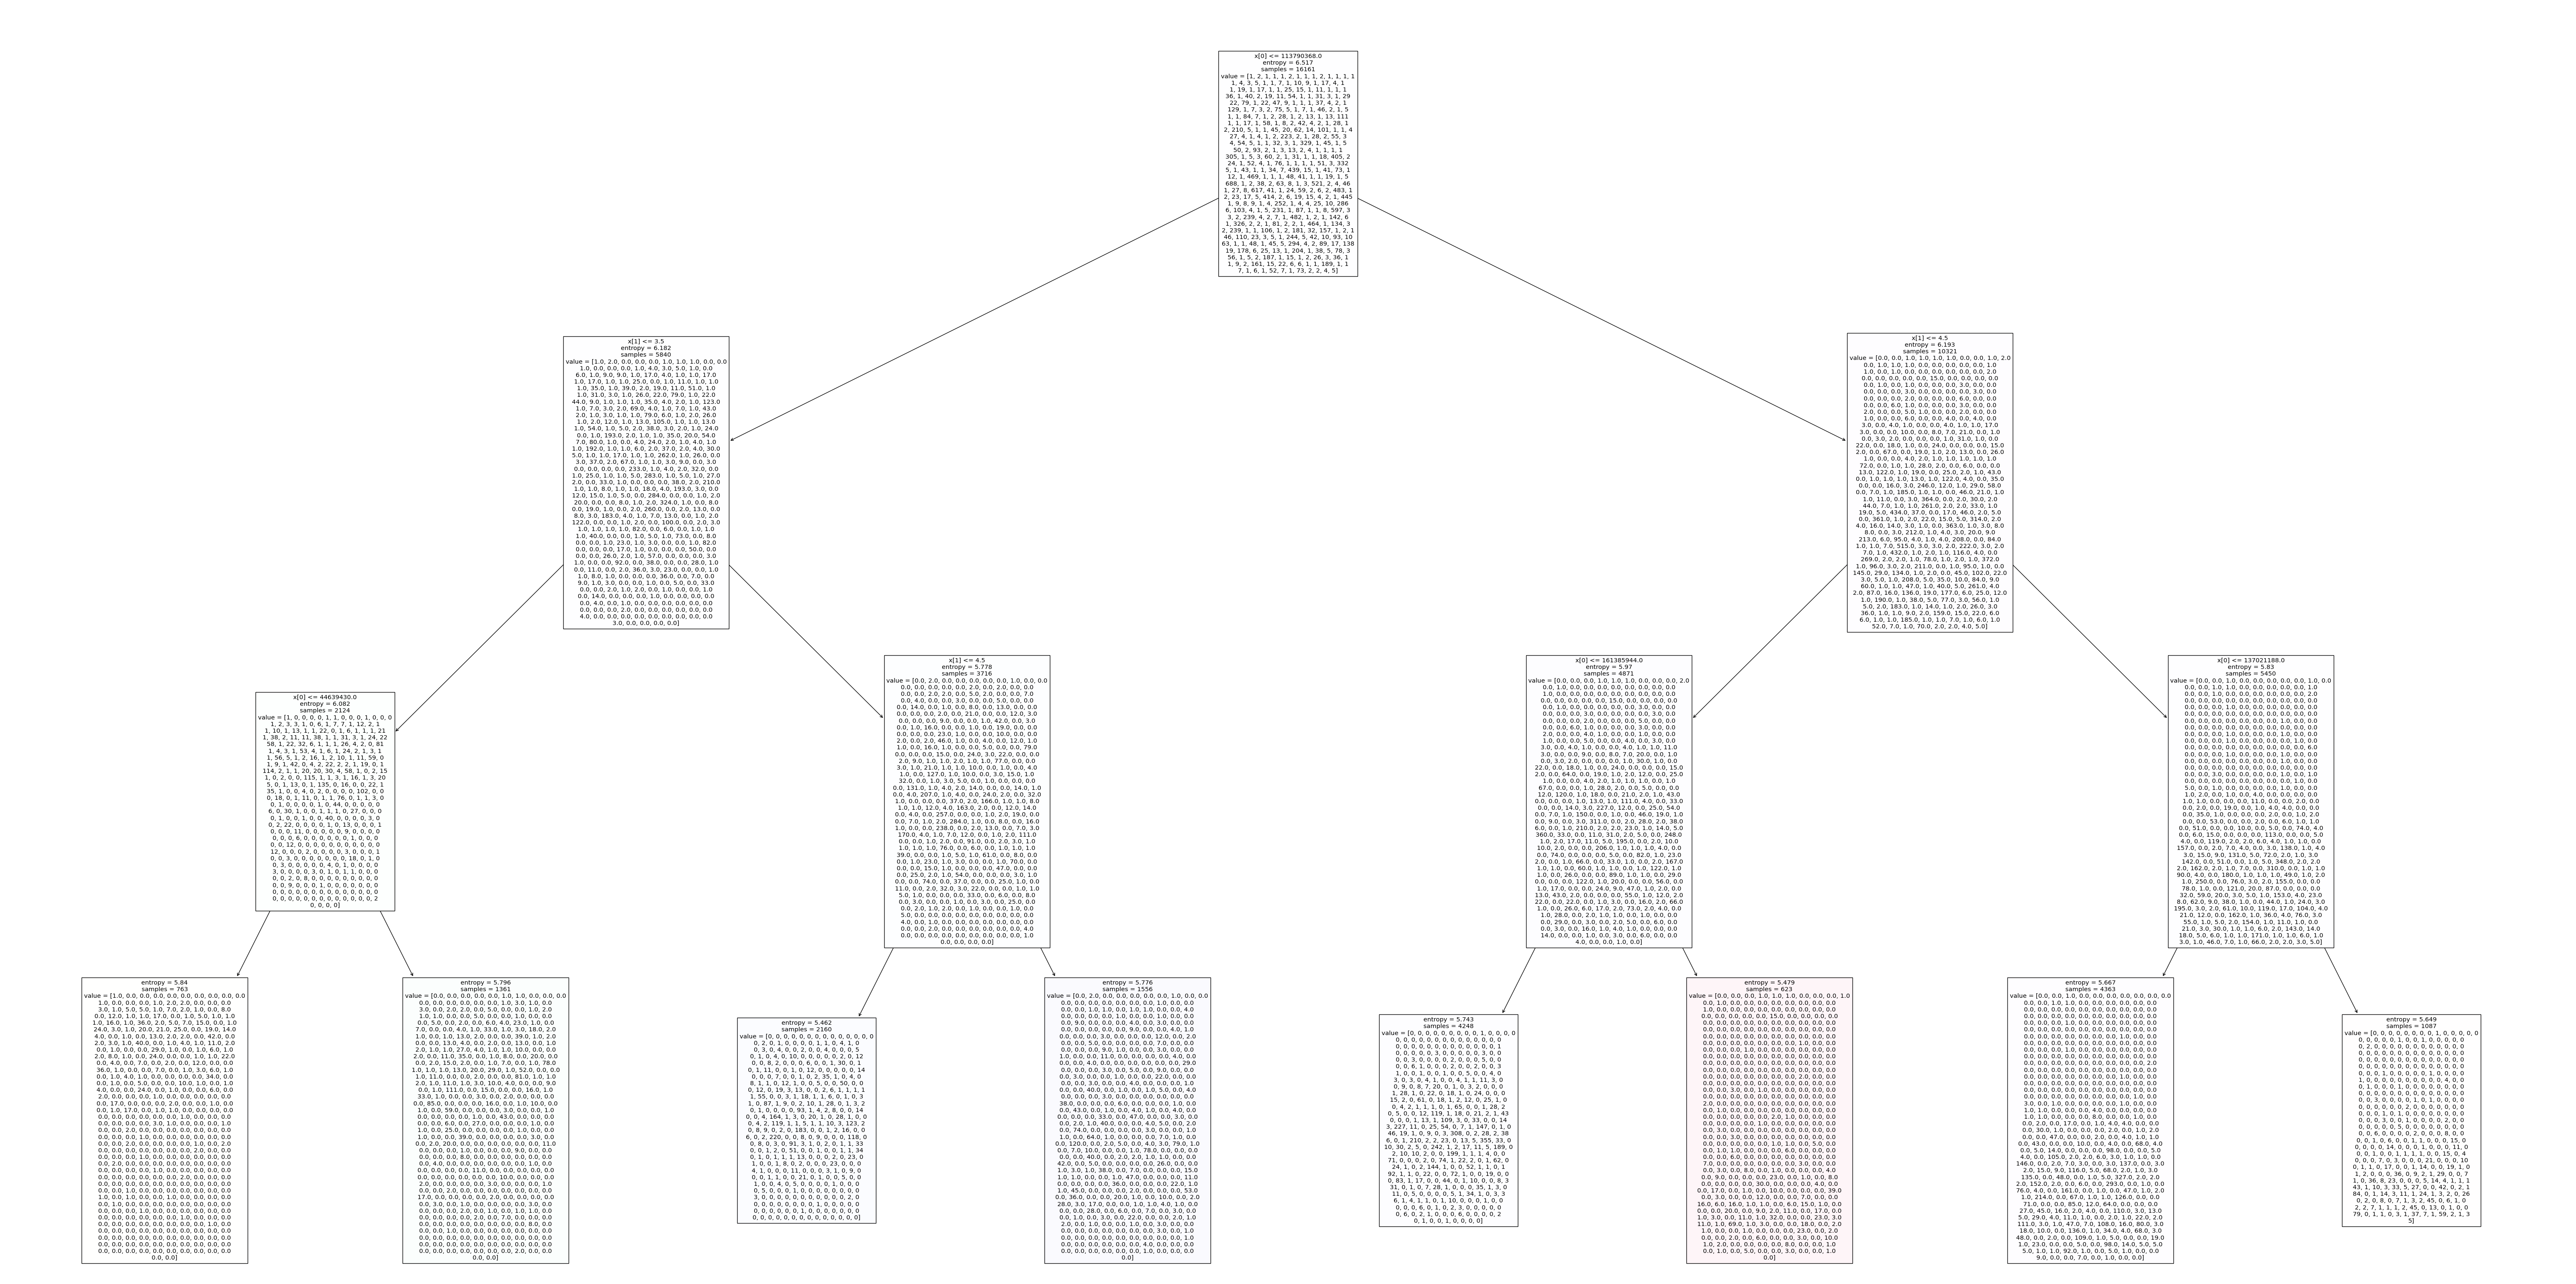

In [49]:
#show decision tree
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (80,40)
tree.plot_tree(rf,filled = True);
#plt.savefig('./images/tree_example.png')

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn import tree

# Create a RandomForestRegressor model
rf = tree.DecisionTreeClassifier(max_depth=5,random_state=42,criterion='entropy')

# Model pipeline
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('random_forest', rf)
                         ])

# Fit model on training data
rf_pipe.fit(X_train, y_train)

# Get predictions on test data
rf_preds = rf_pipe.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)
r2 = r2_score(y_test, rf_preds)

# Print evaluation metrics
print(f'Mean Squared Error (MSE) for a single tree Model: {mse:.2f}')
print(f'Mean Absolute Error (MAE) for a single tree Model: {mae:.2f}')
print(f'R-squared (R2) for for a single tree Model: {r2:.2f}')


Mean Squared Error (MSE) for a single tree Model: 10025479684451800.00
Mean Absolute Error (MAE) for a single tree Model: 58336001.22
R-squared (R2) for for a single tree Model: 0.04


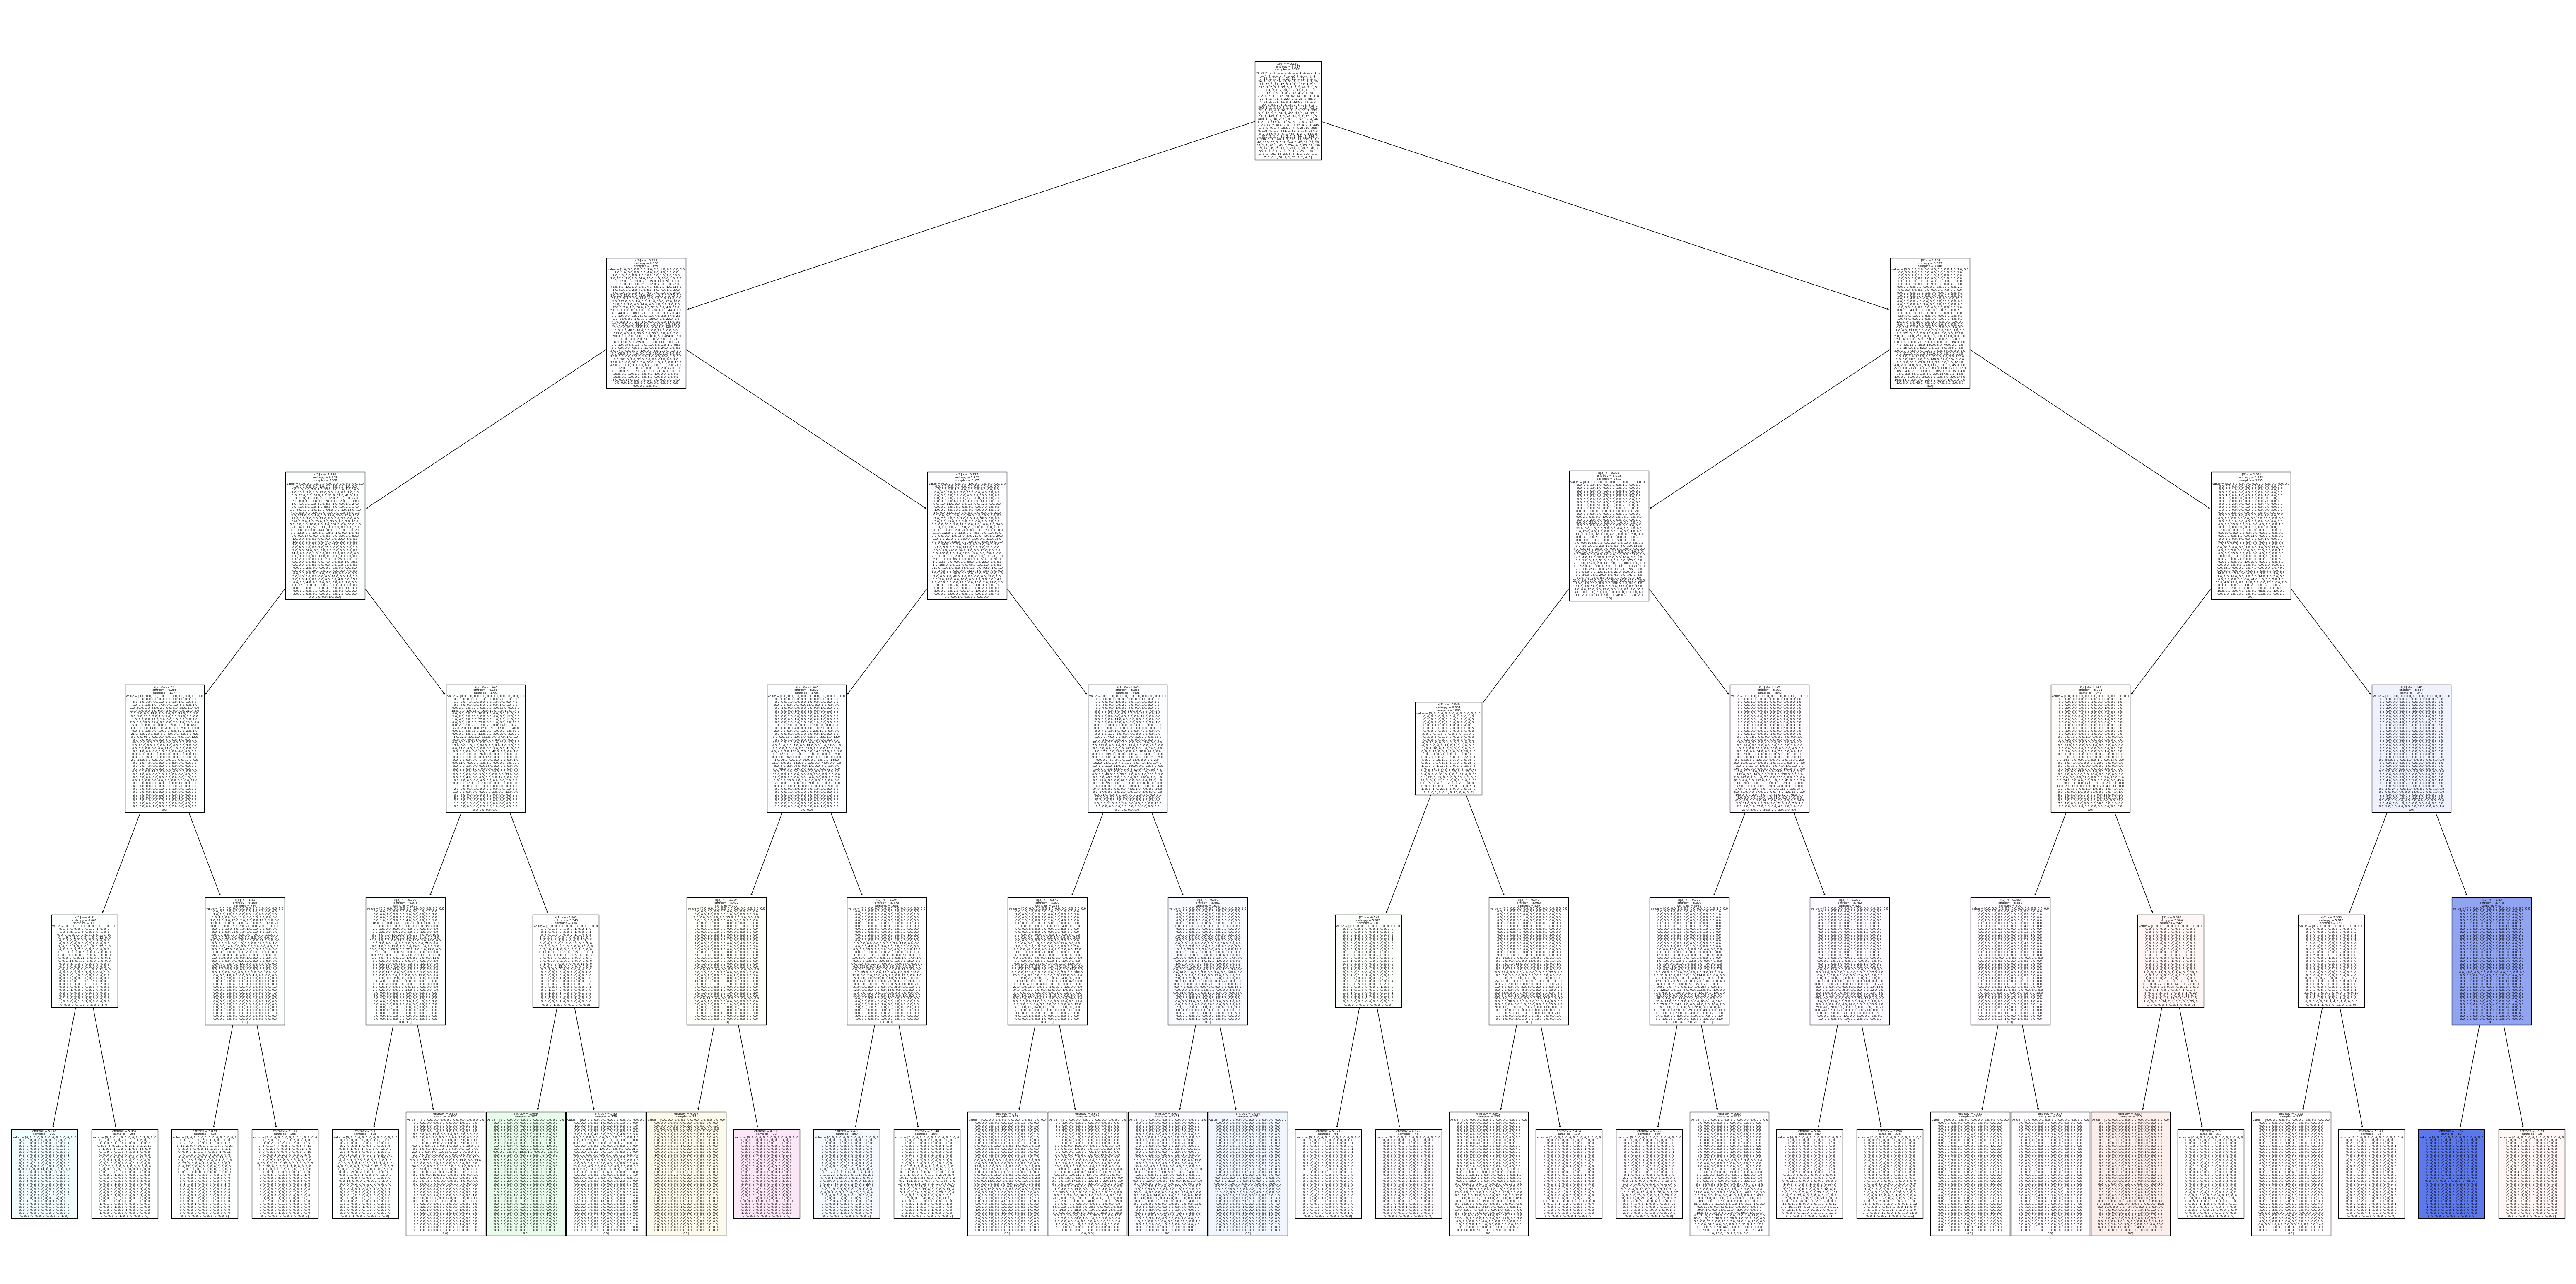

In [114]:
#show decision tree
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (80,40)
tree.plot_tree(rf,filled = True);
#plt.savefig('./images/tree_example.png')

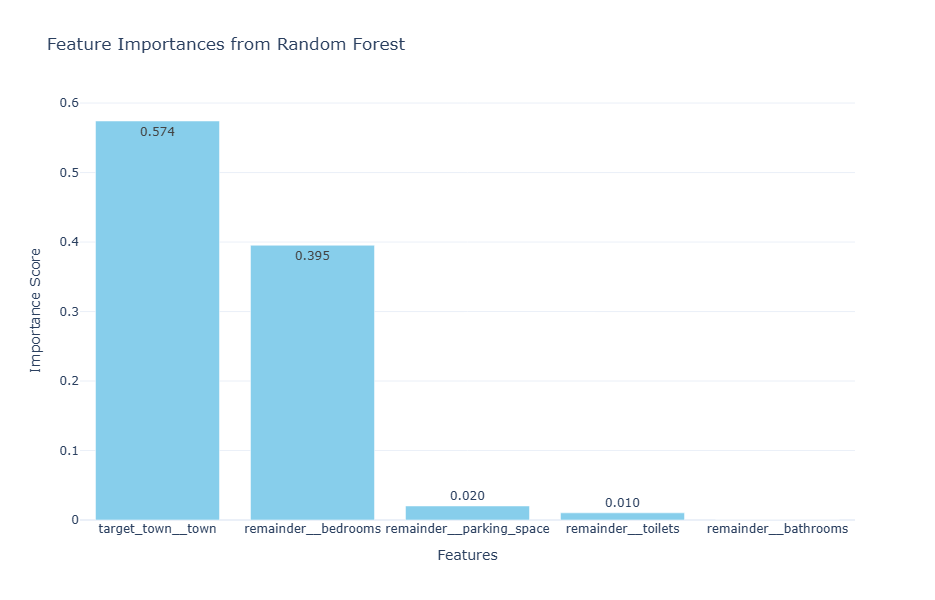

In [43]:
import plotly.graph_objects as go
# Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

importances = rf.feature_importances_

# Get the feature importances from the Random Forest model
# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(feature_names, importances))

# Optional: Sort the dictionary by importance in descending order
feature_importance_sorted = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))

fig = go.Figure(data=[
        go.Bar(
            x=list(feature_importance_sorted.keys()),
            y=list(feature_importance_sorted.values()),
            marker=dict(color='skyblue'),
            text=[f"{v:.3f}" for v in feature_importance_sorted.values()],
            textposition='auto'
        )
    ])

# Update layout for better aesthetics
fig.update_layout(
    title='Feature Importances from Random Forest',
    xaxis_title='Features',
    yaxis_title="Importance Score",
    template='plotly_white',
    height=600
)

# Display the figure
fig.show()